In [1]:
import scipy
import matplotlib.pyplot as plt
import skimage
from skimage import *
from skimage.color import *
from skimage.exposure import *
from skimage.filters import *
from skimage import io
from scipy import ndimage

import numpy as np

In [2]:
# funkcija koja određuje gradijente, magnitudu i ugao gradijenta
def sobel_gradient(image):
    Hx = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])
    # transponovanje matrice
    Hy = np.transpose(Hx)
    
    # izracunavanje vertikalnog i horizontalnog gradijenta slike
    Gx = ndimage.convolve(image, Hx, mode='nearest')
    Gy = ndimage.convolve(image, Hy, mode='nearest')
    
    # magnituda gradijenta
    mag = np.sqrt(np.square(Gx) + np.square(Gy))
    #mag = np.abs(Gx) + np.abs(Gy);
    # pomocna promenljiva kako ne bi izlazio warning za deljenje sa nulom
    Gx_fix = np.copy(Gx)
    Gx_fix[Gx_fix==0] = 1
    angle = np.arctan(np.divide(Gy,Gx_fix))
    angle[(Gx==0)&(Gy>0)] = np.pi/2
    angle[(Gx==0)&(Gy<0)] = -np.pi/2
    angle[(Gx==0) & (Gy==0)] = 0
    return (Gx, Gy, mag, angle)

In [3]:
def canny_edge_detection(img_in, sigma, treshold_low, treshold_high):
    #niskofrekventno filtriranje
    #truncate*sigma=radius, a radius=3*sigma
    img_gauss = skimage.filters.gaussian(img_in, sigma, mode='nearest', truncate=3);
    #izdvajanje gradijenta sobelovim operatorom
    (Gx_g, Gy_g, mag_g, angle_g) = sobel_gradient(img_gauss)
    
    #potiskivanje ne lokalnih maksimuma
    M = np.zeros(np.shape(img_in));
    angle = angle_g*180/np.pi;
    #print(np.max(angle));
    #print(np.min(angle));
        
    for i in range(1,np.shape(img_in)[0]-1):
        for j in range(1,np.shape(img_in)[1]-1):            
            if angle[i,j]>=-22.5 and angle[i,j]<22.5:
                #susedstvo koje posmatramo ako je ugao nula
                a = mag_g[i,j+1];
                b = mag_g[i,j-1];
            elif angle[i,j]>=22.5 and angle[i,j]<67.5:
                #susedstvo koje posmatramo ako je ugao 45 stepeni
                a = mag_g[i+1,j-1];
                b = mag_g[i-1,j+1];
            elif angle[i,j]>=67.5 or angle[i,j]<-67.5:
                #ugao je 90 stepeni
                a = mag_g[i+1,j];
                b = mag_g[i-1,j];
            else:
                #ugao je -45 stepeni
                a = mag_g[i-1,j-1];
                b = mag_g[i+1,j+1];
            if mag_g[i,j]>=a and mag_g[i,j]>=b:
                M[i,j] = mag_g[i,j];
            
    #plt.figure()
    #plt.imshow(M,cmap='gray');
    #plt.show()
    #figure, ax=plt.subplots(nrows=2, ncols=2, figsize=(20,16), dpi=80)

    #ax[0,0].imshow(image, cmap='gray', vmin=0, vmax=1), ax[0,0].set_title('Originalna slika'), ax[0,0].axis('off')
    #ax[1,0].imshow(image, cmap='gray', vmin=0, vmax=1), ax[1,0].set_title('Originalna slika'), ax[1,0].axis('off')
    #ax[0,1].imshow(Gx_g, cmap='gray', vmin=np.amin(Gx_g), vmax=np.amax(Gx_g)), ax[0,1].set_title('Horizontalne ivice - vertikalni gradijent)'), ax[0,1].axis('off')
    #ax[1,1].imshow(Gy_g, cmap='gray', vmin=np.amin(Gy_g), vmax=np.amax(Gy_g)), ax[1,1].set_title('Vertikalne ivice - horizontalni gradijent'), ax[1,1].axis('off')
    #matplotlib.pyplot.tight_layout()
    #plt.show()
    
    
    # Maska ivica dobijena poredjenjem sa pragom
    tl = np.max(mag_g)*treshold_low;
    th = np.max(mag_g)*treshold_high;
    maska = np.zeros(np.shape(mag_g));
    i,j = np.where(mag_g>=th);
    maska[i,j] = 255;
    i,j = np.where((mag_g>=tl) & (mag_g<th));
    maska[i,j] = 125;
    
    #ukljucivanje slabih ivica
    #DA LI PROLAZITI VISE PUTA KROZ SLIKU KAO STO PISE NA PREDAVANJU ???
    sum = len(maska[maska==255]);
    br=1
    for i in range(1,np.shape(img_in)[0]-1):
        for j in range(1,np.shape(img_in)[1]-1):
            if maska[i,j]==125:
                maska[i,j]= 255*(maska[i-1,j-1]==255 or maska[i-1,j]==255 or maska[i-1,j+1]==255 or maska[i,j-1]==255 or maska[i,j+1]==255 or maska[i+1,j-1]==255 or maska[i+1,j]==255 or maska[i+1,j+1]==255);
    pret = sum;
    sum=len(maska[maska==255]);
    while (pret!=sum):
        br+=1;
        print(br)
        for i in range(1,np.shape(img_in)[0]-1):
            for j in range(1,np.shape(img_in)[1]-1):
                if maska[i,j]==125:
                    maska[i,j]= 255*(maska[i-1,j-1]==255 or maska[i-1,j]==255 or maska[i-1,j+1]==255 or maska[i,j-1]==255 or maska[i,j+1]==255 or maska[i+1,j-1]==255 or maska[i+1,j]==255 or maska[i+1,j+1]==255);
        pret=sum;
        sum = len(maska[maska==255]);
    #edge_mask1 = np.zeros_like(mag_g);
    #edge_mask1[mag_g<treshold_low] = 1;
    #edge_mask2 = np.zeros_like(mag_g);
    #edge_mask2[mag_g>treshold_high] = 1;
    
    #plt.figure()
    #plt.imshow(maska,cmap='gray')
    #plt.show()
    return maska;

In [48]:
def distance_between(first, last):
    return np.sqrt((first[0]-last[0])**2 + (first[1]-last[1])**2)

def valid(x, y, img):
    if x < 0 or x >= len(img) or y < 0 or y >= len(img[0]):
        return False
    return True

def find_white(img_edges, x, y, delta):
    for dx in range(int(-delta/2), int(delta/2+1)):
        for dy in range(int(-delta/2), int(delta/2+1)):
            if not valid(x+dx, y+dy, img_edges):
                continue
            if(img_edges[x+dx][y+dy] != 0):
                return True
    return False

def get_line_segmentation(img_edges,line,min_size,max_gaps,tolerancy):
    theta,rho = line[0],line[1];
    duzi = [];
    #x = rho*np.cos(theta);
    #y = rho*np.sin(theta);
    alfa=0;
    n = 0;
    x_alt=-1;
    if theta>0 and theta<np.pi/2:
        alfa = np.pi/2+theta;
        n = rho/np.sin(theta);
    elif theta<0 and theta>-np.pi/2:
        alfa = np.pi/2-np.abs(theta);
        #n = -rho/np.sin(np.abs(theta));
        n = rho/np.sin(np.abs(theta))
    elif theta>np.pi/2 and theta<np.pi:
        alfa = np.pi-theta;
        n = rho/np.sin(np.pi-theta);
    elif theta==0:        
        n = 0;
        alfa = np.pi/2;
        x_alt=rho;
    elif theta==np.pi/2:
        n = rho;
        alfa=0;
    else:
        print("Nevalidna vrednost za theta");
        return -1
    
    pravac = [];
    linija = [];
    duz=0;
    gap=0;
    last=[];
    lastWhite = []
    firstBlack, lastBlack = [], []
    
    if (x_alt!=-1):
        x=rho;
        for y in range(np.shape(img_edges)[1]):
            if find_white(img_edges, x, y, tolerancy):
                
                if duz==0:
                    linija.append([x,y]);
                    duz=1;
                    firstBlack, lastBlack = [], []
                lastWhite = [x, y]
            else:
                lastBlack = [x, y]
                if (firstBlack == []):
                    firstBlack = [x, y]
                gap = distance_between(firstBlack, lastBlack);
                if gap>max_gaps:
                    if len(linija) > 0:
                        duz = distance_between(linija[0], lastWhite)
                    if duz >= min_size:
                        linija.append(lastWhite)
                        linija.append(duz)
                        pravac.append(linija)                       
                    gap=0;
                    duz=0;
                    linija=[];
    else:      
        crne = 0
        for x in range(np.shape(img_edges)[0]):
            if (x_alt!=-1):
                break            
            y = int(x*np.tan(alfa)+n);
            if (y>=np.shape(img_edges)[1] or y<0):
                continue
            if find_white(img_edges, x, y, tolerancy):            
                if duz==0:
                    linija.append([x, y])
                    duz = 1
                    firstBlack, lastBlack = [], []
                lastWhite = [x, y]
            else:
                lastBlack = [x, y]
                if (firstBlack == []):
                    firstBlack = [x, y]
                gap = distance_between(firstBlack, lastBlack)
                if gap>max_gaps:
                    if len(linija) > 0:
                        duz = distance_between(linija[0], lastWhite)
                    if duz >= min_size:
                        centar = [np.shape(img_edges)[0]/2,np.shape(img_edges)[1]/2];
                        if (distance_between(linija[0],centar)<=100 or distance_between(lastWhite,centar)<=100):
                            linija.append(lastWhite)
                            linija.append(duz)
                            pravac.append(linija)
                    duz = 0
                    linija = []
            
    #print(pravac);
    if (len(pravac)>0):
        plt.figure()
        plt.imshow(img_edges);
        y_values = [pravac[0][0][0], pravac[0][1][0]]
        x_values = [pravac[0][0][1], pravac[0][1][1]]
        plt.plot(x_values, y_values,'r')
        plt.show()
            
   
                

2


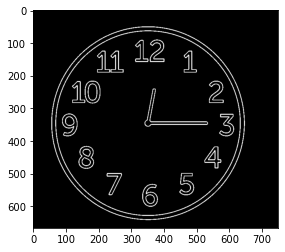

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


[1.57079633 0.18428337]
D=[350, 412]
A=[0.         1.38651296]


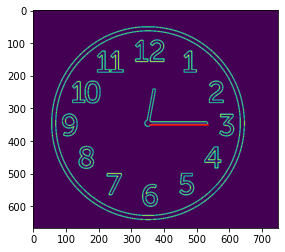

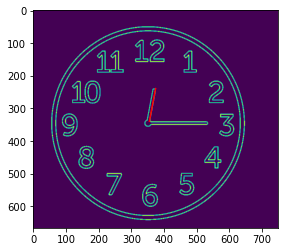

2


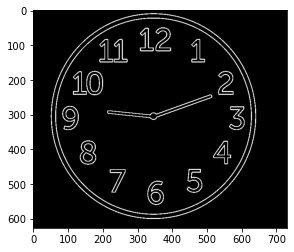

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


[ 1.23733118 -1.46549155]
D=[406, 271]
A=[ 0.33346514 -0.10530478]


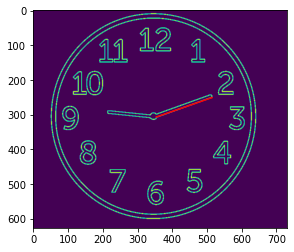

2


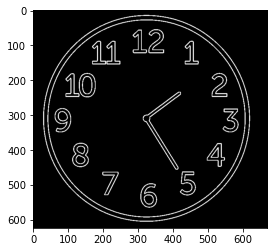

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


[-0.5528501   0.93896764]
D=[116, 436]
A=[-1.01794622  0.63182869]


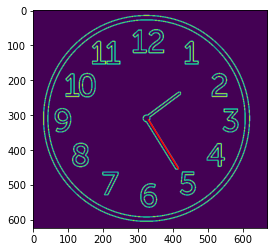

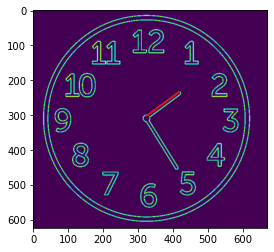

2


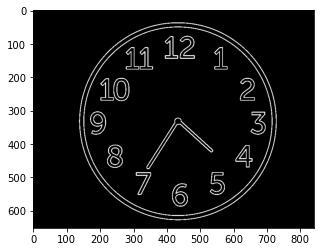

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


[ 0.5704009  -0.81611206]
D=[548, 63]
A=[ 1.00039543 -0.75468427]


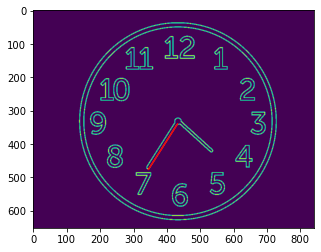

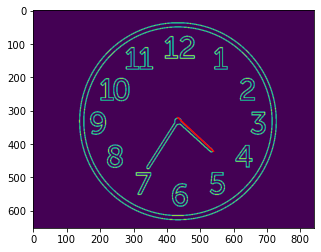

2


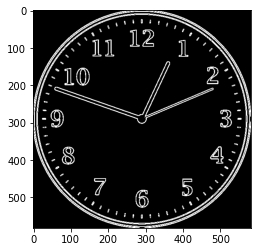

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


[-1.23733118  1.167128  ]
D=[181, 379]
A=[-0.33346514  0.40366833]


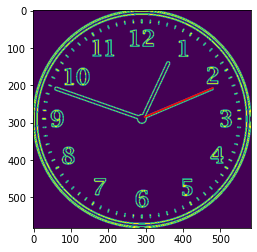

2


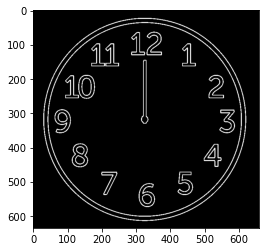

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


[0.0087754  1.57079633]
D=[324, 162]
A=[1.56202093 0.        ]


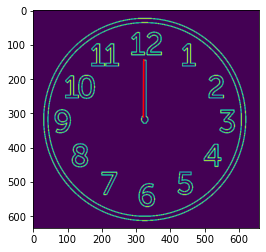

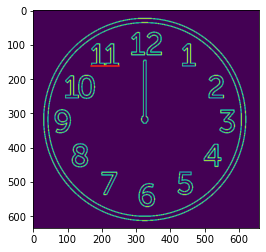

2


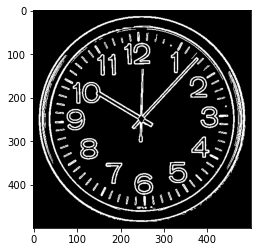

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


[0.74590887 0.0263262 ]
D=[349, 253]
A=[0.82488746 1.54447013]


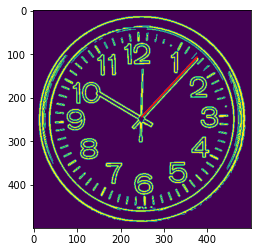

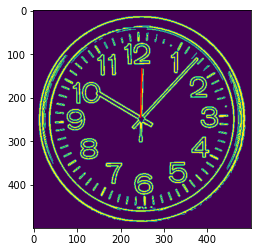

2


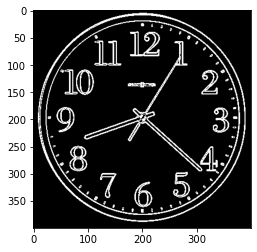

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


[ 0.5528501  -0.85121365]
D=[273, 18]
A=[ 1.01794622 -0.71958267]


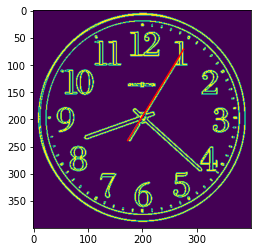

<ipython-input-49-3587420af4af>:10: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  ul_slika = rgb2gray(image)


2


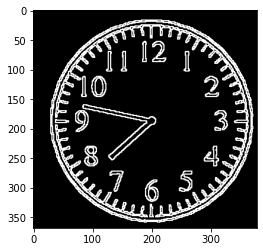

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


[-1.36018676  0.86876445]
D=[142, 277]
A=[-0.21060956  0.70203188]


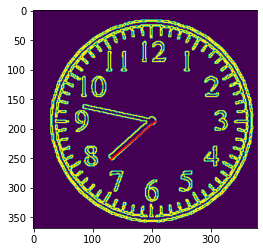

In [49]:
i=2;
for i in range(1,10):
    if i in {7, 8}:
        image = io.imread(f'clock{i}.jpg')
        image = skimage.img_as_float(image)
        ul_slika = rgb2gray(image)
    elif i in {5}:
        image = io.imread(f'clock{i}.png')
        image = skimage.img_as_float(image)
        ul_slika = rgb2gray(image)
    else:
        image = io.imread(f'clock{i}.png')
        image = skimage.img_as_float(image)
        ul_slika = rgb2gray(rgba2rgb(image))
    
    #image = io.imread(f'clock{i}.png')
    #image = skimage.img_as_float(image)
    #ul_slika = rgb2gray(rgba2rgb(image))
    #ul_slika = rgb2gray(image)

    iout=canny_edge_detection(ul_slika,0.2,0.2,0.4);
    plt.figure()
    plt.imshow(iout,cmap='gray')

    plt.show()
    io.imsave('ivicesat.jpg',iout)


    a=skimage.transform.hough_line(iout)
    #print(type(a))
    b=skimage.transform.hough_line_peaks(*a,min_distance=40,num_peaks=2);
    _,angles,distances = b
    print(angles)
    angles = np.sign(angles)*np.pi/2-angles;
    distances = [int(np.abs(d)) for d in distances];
    print(f"D={distances}")
    print(f"A={angles}")
    for theta,rho in zip(angles,distances):
        #print("Theta={the}".format(the=theta))
        #print("Ro={ro}".format(ro=rho))
        #for t in range(-10,11):
        #    get_line_segmentation(iout,[theta,rho+t],50,5,2)
        get_line_segmentation(iout,[theta,rho],50,5,2)

    #get_line_segmentation(iout,[1.3865,412],50,5,5)



(652, 842, 3)


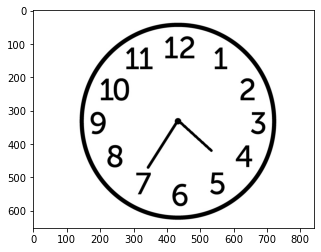

In [32]:
print(np.shape(ul_slika))
plt.figure()
plt.imshow(ul_slika)